## ESMACS binding free energy application

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the ESMACS application. Small variation in the results will occur due to the stochastic nature of the training procedure.

### Reference

*Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [1]:
#!pip install easysurrogate==0.24.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [3]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [4]:
%matplotlib inline
# save figures at 300 dpi
plt.rcParams['savefig.dpi'] = 300

### Load prior ranges

The JSON files below contains all default values and boundaries used for specifying the Uniform input parameter distributions. 

In [5]:
# Load the EasyVVUQ params dicts, containing the default values and type of each input
priors = {}
# there are 5 inputs files, each with a seperate params dict
prior_fnames = os.listdir('./priors')
for fname in prior_fnames:
    prior = json.load(open('./priors/%s' % fname, 'r'))
    priors = priors | prior
priors

{'d01fc': {'default': 0.75, 'type': 'float'},
 'd02fc': {'default': 0.25, 'type': 'float'},
 'd03fc': {'default': 0.092, 'type': 'float'},
 'd04fc': {'default': 0.612, 'type': 'float'},
 'd05fc': {'default': 0.252, 'type': 'float'},
 'd06fc': {'default': 0.03, 'type': 'float'},
 'd07fc': {'default': 0.154, 'type': 'float'},
 'd08fc': {'default': 0.486, 'type': 'float'},
 'd09fc': {'default': 0.033, 'type': 'float'},
 'd10fc': {'default': 1.0, 'type': 'float'},
 'd11fc': {'default': 0.45, 'type': 'float'},
 'd12fc': {'default': 0.0, 'type': 'float'},
 'd13fc': {'default': 0.53, 'type': 'float'},
 'd14fc': {'default': 0.15, 'type': 'float'},
 'd15fc': {'default': 0.5, 'type': 'float'},
 'd16fc': {'default': 1.5, 'type': 'float'},
 'd17fc': {'default': 1.05, 'type': 'float'},
 'd18fc': {'default': 10.5, 'type': 'float'},
 'd19fc': {'default': 1.1, 'type': 'float'},
 'd20fc': {'default': 1.0, 'type': 'float'},
 'box_size': {'default': 14.0, 'type': 'float'},
 'cutoff': {'default': 12.0, 't

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [6]:
# input parameters
params = pd.read_csv('./data_esmacs/esmacs_inputs.csv')
param_names = params.keys()
params = params.values

# number of code samples
n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])

# except the temperature
idx_T = np.where(param_names == 'setTemperature')[0]
p_max[idx_T] = np.array(priors['setTemperature']['default'] * 1.075)
p_min[idx_T] = np.array(priors['setTemperature']['default'] * 0.925)

# scale inputs within [-1, 1]
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

### Load output samples

Load the corresponding Monte Carlo outputs, in the case the binding free energy predictions.

In [7]:
QoI = 'binding_energy'
output = pd.read_csv('./data_esmacs/%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [8]:
# average the data over the replica simulations or not
average_over_replicas = True

if not average_over_replicas:
    samples = output[:, 0].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [9]:
d = 1

### Set hyperparameters

In [10]:
# number of neurons per hidden layer 
n_hidden_neurons = 20
# number of hidden layer + output layer
n_layers = 3
# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [11]:
test_frac = 0.1
test_idx = int((1 - test_frac) * n_samples)
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [12]:
n_rep = 20

### Train a deep active subspace network


In [13]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [14]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
        # W_1 = das_surrogate.neural_net.layers[1].W
        # results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.5`.

In [15]:
train_das(failure_criterion=0.5)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  662/662 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 167
Loss function = squared
Number of neurons per hidden layer = 20
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 228 weights.
Training Deep Active Subspace Neural Network...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 392.51it/s]


 loss = 0.9955
Relative training error = 23.1702 %
Relative test error = 22.8485 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 524.74it/s]


 loss = 0.9046
Relative training error = 20.4072 %
Relative test error = 22.2354 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 516.12it/s]


 loss = 0.9588
Relative training error = 16.7208 %
Relative test error = 20.8706 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 499.49it/s]


 loss = 0.5077
Relative training error = 13.6592 %
Relative test error = 18.1507 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 430.83it/s]

 loss = 0.2613


Relative training error = 11.7106 %
Relative test error = 15.1194 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 541.78it/s]


 loss = 0.2169
Relative training error = 10.3924 %
Relative test error = 13.3183 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.76it/s]

 loss = 0.3296
Relative training error = 9.5453 %
Relative test error = 11.8766 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 543.33it/s]


 loss = 0.1543
Relative training error = 9.1216 %
Relative test error = 11.2492 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 404.46it/s]


 loss = 0.1196
Relative training error = 8.8257 %
Relative test error = 10.0142 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.77it/s]


 loss = 0.0996
Relative training error = 8.5999 %
Relative test error = 9.8984 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 454.29it/s]

 loss = 0.0724


Relative training error = 8.4439 %
Relative test error = 9.2241 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 439.06it/s]

 loss = 0.0806


Relative training error = 8.3098 %
Relative test error = 9.6130 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 431.79it/s]

 loss = 0.0738


Relative training error = 8.3921 %
Relative test error = 9.9672 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 541.12it/s]

 loss = 0.0791


Relative training error = 8.3342 %
Relative test error = 10.1002 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.47it/s]


 loss = 0.1324
Relative training error = 8.2303 %
Relative test error = 10.3239 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.90it/s]

 loss = 2.0289
Relative training error = 23.6068 %


Relative test error = 22.5843 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 546.12it/s]

 loss = 1.1905
Relative training error = 20.4991 %
Relative test error = 21.1133 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 515.03it/s]

 loss = 1.0883


Relative training error = 16.8859 %
Relative test error = 18.3346 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 554.23it/s]


 loss = 0.5126
Relative training error = 14.0085 %
Relative test error = 16.2911 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.16it/s]

 loss = 0.2841


Relative training error = 11.9424 %
Relative test error = 14.8592 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 471.93it/s]

 loss = 0.1593


Relative training error = 10.5948 %
Relative test error = 14.0578 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 454.27it/s]

 loss = 0.1179


Relative training error = 9.7181 %
Relative test error = 12.1900 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.00it/s]

 loss = 0.1057


Relative training error = 9.1785 %
Relative test error = 11.4414 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 424.35it/s]

 loss = 0.1208


Relative training error = 8.7587 %
Relative test error = 10.5230 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.58it/s]

 loss = 0.1010


Relative training error = 8.5774 %
Relative test error = 9.9991 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 537.29it/s]

 loss = 0.1294


Relative training error = 8.4278 %
Relative test error = 9.3792 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.31it/s]

 loss = 0.1257


Relative training error = 8.3027 %
Relative test error = 9.5642 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.63it/s]


 loss = 0.1046
Relative training error = 8.2416 %
Relative test error = 9.6801 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 526.04it/s]

 loss = 0.0627
Relative training error = 8.2222 %


Relative test error = 10.0516 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.21it/s]

 loss = 0.2240


Relative training error = 8.2424 %
Relative test error = 9.9703 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.21it/s]

 loss = 1.0841


Relative training error = 23.6788 %
Relative test error = 22.8528 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 502.67it/s]

 loss = 0.8681


Relative training error = 22.6918 %
Relative test error = 23.3662 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 570.08it/s]

 loss = 1.0776


Relative training error = 19.1879 %
Relative test error = 21.8961 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.01it/s]

 loss = 0.9817


Relative training error = 15.7432 %
Relative test error = 18.9455 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 386.81it/s]

 loss = 0.7193


Relative training error = 12.9026 %
Relative test error = 15.7476 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.93it/s]

 loss = 0.3840


Relative training error = 11.0564 %
Relative test error = 13.3653 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.03it/s]


 loss = 0.2173
Relative training error = 9.8932 %
Relative test error = 11.6775 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.87it/s]

 loss = 0.1161


Relative training error = 9.0320 %
Relative test error = 10.3625 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.55it/s]


 loss = 0.1654
Relative training error = 8.6385 %
Relative test error = 9.8426 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 534.64it/s]

 loss = 0.1480


Relative training error = 8.3839 %
Relative test error = 9.8111 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 569.62it/s]

 loss = 0.0896
Relative training error = 8.3089 %


Relative test error = 9.8899 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.62it/s]


 loss = 0.1867
Relative training error = 8.2178 %
Relative test error = 9.7828 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.03it/s]

 loss = 0.0749
Relative training error = 8.0838 %


Relative test error = 9.5367 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.26it/s]

 loss = 0.1120


Relative training error = 8.0949 %
Relative test error = 9.4731 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.27it/s]


 loss = 0.0708
Relative training error = 8.0669 %
Relative test error = 9.4938 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 532.48it/s]

 loss = 0.1907


Relative training error = 8.0254 %
Relative test error = 9.6406 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 317.94it/s]


 loss = 0.0684
Relative training error = 8.0249 %
Relative test error = 9.6326 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.74it/s]

 loss = 1.0697


Relative training error = 23.0301 %
Relative test error = 21.8956 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.84it/s]

 loss = 1.0448


Relative training error = 19.4801 %
Relative test error = 19.0187 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 441.01it/s]

 loss = 0.7578


Relative training error = 15.0219 %
Relative test error = 17.1884 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 475.81it/s]


 loss = 0.3563
Relative training error = 12.3236 %
Relative test error = 15.0041 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.13it/s]

 loss = 0.3198


Relative training error = 10.5481 %
Relative test error = 12.9995 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 514.89it/s]


 loss = 0.2502
Relative training error = 9.5197 %
Relative test error = 11.6365 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 531.13it/s]

 loss = 0.1167
Relative training error = 9.0210 %


Relative test error = 10.8360 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 574.68it/s]


 loss = 0.1239
Relative training error = 8.6716 %
Relative test error = 10.3907 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 549.48it/s]

 loss = 0.0956


Relative training error = 8.4846 %
Relative test error = 9.7646 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.88it/s]

 loss = 0.1431


Relative training error = 8.3094 %
Relative test error = 9.6462 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.62it/s]

 loss = 0.1042


Relative training error = 8.2729 %
Relative test error = 9.6730 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.78it/s]

 loss = 0.0816


Relative training error = 8.1909 %
Relative test error = 9.6240 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.07it/s]

 loss = 0.0830


Relative training error = 8.1662 %
Relative test error = 9.7561 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 422.71it/s]

 loss = 0.0837


Relative training error = 8.1821 %
Relative test error = 9.9243 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.18it/s]

 loss = 1.0528


Relative training error = 21.8604 %
Relative test error = 23.6352 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.31it/s]

 loss = 0.8219


Relative training error = 18.0038 %
Relative test error = 21.6042 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 516.63it/s]

 loss = 0.3943


Relative training error = 14.1451 %
Relative test error = 17.9272 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.50it/s]

 loss = 0.4967


Relative training error = 11.6368 %
Relative test error = 14.0616 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.57it/s]


 loss = 0.2500
Relative training error = 10.1774 %
Relative test error = 12.1428 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 469.76it/s]

 loss = 0.1886


Relative training error = 9.3816 %
Relative test error = 11.2031 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 526.74it/s]


 loss = 0.1070
Relative training error = 8.9533 %
Relative test error = 10.7390 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 550.78it/s]

 loss = 0.0955
Relative training error = 8.6364 %


Relative test error = 10.4757 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 542.23it/s]


 loss = 0.1793
Relative training error = 8.4933 %
Relative test error = 10.3679 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 529.17it/s]

 loss = 0.1083


Relative training error = 8.3510 %
Relative test error = 10.1278 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.19it/s]


 loss = 0.0694
Relative training error = 8.2555 %
Relative test error = 9.9378 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.09it/s]

 loss = 0.1542


Relative training error = 8.2475 %
Relative test error = 9.8103 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 530.24it/s]

 loss = 0.1385


Relative training error = 8.2811 %
Relative test error = 9.8252 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 571.73it/s]

 loss = 0.1121


Relative training error = 8.1919 %
Relative test error = 9.6486 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 518.75it/s]


 loss = 0.0701
Relative training error = 8.1691 %
Relative test error = 9.6029 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 523.62it/s]

 loss = 0.0749


Relative training error = 8.1522 %
Relative test error = 9.8285 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 491.10it/s]

 loss = 0.1503


Relative training error = 8.2049 %
Relative test error = 9.3297 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.34it/s]

 loss = 0.0863


Relative training error = 8.2059 %
Relative test error = 9.7959 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 566.02it/s]

 loss = 0.1571


Relative training error = 8.1217 %
Relative test error = 9.4230 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.42it/s]

 loss = 0.0594


Relative training error = 8.1121 %
Relative test error = 9.2894 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 436.43it/s]

 loss = 0.0895


Relative training error = 8.1077 %
Relative test error = 9.1771 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.47it/s]

 loss = 0.1721


Relative training error = 8.1265 %
Relative test error = 9.3771 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.89it/s]

 loss = 0.1124
Relative training error = 8.1293 %


Relative test error = 9.6797 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.76it/s]


 loss = 0.1419
Relative training error = 8.0487 %
Relative test error = 9.6110 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 531.28it/s]


 loss = 0.0788
Relative training error = 8.1328 %
Relative test error = 9.7494 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 549.16it/s]

 loss = 1.2704
Relative training error = 23.0254 %
Relative test error = 22.4123 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.65it/s]


 loss = 1.4567
Relative training error = 18.6087 %
Relative test error = 20.1899 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 439.25it/s]


 loss = 0.6443
Relative training error = 15.2138 %
Relative test error = 18.2406 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 442.37it/s]


 loss = 0.3780
Relative training error = 13.1125 %
Relative test error = 16.0078 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 554.25it/s]


 loss = 0.3001
Relative training error = 11.4491 %
Relative test error = 14.1804 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 438.04it/s]

 loss = 0.2679


Relative training error = 10.2664 %
Relative test error = 12.4897 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.15it/s]


 loss = 0.1610
Relative training error = 9.5851 %
Relative test error = 12.0460 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 556.05it/s]

 loss = 0.1544


Relative training error = 9.0964 %
Relative test error = 10.8414 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 535.68it/s]


 loss = 0.1089
Relative training error = 8.7802 %
Relative test error = 10.3947 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.60it/s]


 loss = 0.0887
Relative training error = 8.6705 %
Relative test error = 9.9634 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.58it/s]


 loss = 0.1647
Relative training error = 8.5079 %
Relative test error = 10.2780 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.81it/s]

 loss = 0.1572


Relative training error = 8.4126 %
Relative test error = 10.4974 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 536.75it/s]

 loss = 0.0860


Relative training error = 8.3242 %
Relative test error = 10.2099 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 469.45it/s]

 loss = 0.1028


Relative training error = 8.2981 %
Relative test error = 10.0334 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 550.01it/s]

 loss = 0.0815
Relative training error = 8.2851 %


Relative test error = 9.7901 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 398.04it/s]

 loss = 0.0593


Relative training error = 8.1966 %
Relative test error = 9.7487 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 436.39it/s]

 loss = 0.0908


Relative training error = 8.1249 %
Relative test error = 9.7334 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 558.48it/s]

 loss = 0.1596


Relative training error = 8.1184 %
Relative test error = 9.7668 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 507.35it/s]

 loss = 0.1297


Relative training error = 8.1344 %
Relative test error = 10.0250 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 553.99it/s]

 loss = 2.4005
Relative training error = 24.0631 %
Relative test error = 22.5349 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.82it/s]

 loss = 0.7315


Relative training error = 22.7062 %
Relative test error = 21.2032 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.43it/s]


 loss = 0.8723
Relative training error = 20.2508 %
Relative test error = 20.3030 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 551.02it/s]

 loss = 0.5967


Relative training error = 17.3002 %
Relative test error = 18.9236 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.44it/s]

 loss = 0.5687


Relative training error = 14.5665 %
Relative test error = 16.7517 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.74it/s]

 loss = 0.3163


Relative training error = 12.4772 %
Relative test error = 14.5468 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 435.12it/s]

 loss = 0.2844


Relative training error = 11.0318 %
Relative test error = 12.3127 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 516.43it/s]

 loss = 0.2106


Relative training error = 10.2413 %
Relative test error = 11.0973 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 483.40it/s]

 loss = 0.1325


Relative training error = 9.6155 %
Relative test error = 10.5055 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 441.01it/s]

 loss = 0.1444


Relative training error = 9.1740 %
Relative test error = 10.1817 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.92it/s]

 loss = 0.1307


Relative training error = 8.9714 %
Relative test error = 10.2039 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.22it/s]

 loss = 0.1355
Relative training error = 8.8209 %


Relative test error = 10.1601 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.10it/s]

 loss = 0.1961


Relative training error = 8.6051 %
Relative test error = 10.1163 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.32it/s]

 loss = 0.1926


Relative training error = 8.5176 %
Relative test error = 9.9850 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 529.35it/s]

 loss = 0.8111


Relative training error = 20.7115 %
Relative test error = 21.1646 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.36it/s]

 loss = 0.7311
Relative training error = 16.4139 %
Relative test error = 19.5397 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.29it/s]


 loss = 0.5709
Relative training error = 13.4631 %
Relative test error = 16.1154 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 546.63it/s]


 loss = 0.3419
Relative training error = 11.7343 %
Relative test error = 14.4410 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 531.05it/s]

 loss = 0.1609


Relative training error = 10.5628 %
Relative test error = 12.7663 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 421.84it/s]


 loss = 0.2035
Relative training error = 9.7581 %
Relative test error = 11.8756 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 559.42it/s]


 loss = 0.1116
Relative training error = 9.2109 %
Relative test error = 10.7231 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.55it/s]


 loss = 0.0916
Relative training error = 8.9843 %
Relative test error = 10.1591 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 478.42it/s]


 loss = 0.1174
Relative training error = 8.5896 %
Relative test error = 10.1798 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 524.84it/s]

 loss = 0.0948


Relative training error = 8.4163 %
Relative test error = 9.9094 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.27it/s]


 loss = 0.1808
Relative training error = 8.3169 %
Relative test error = 9.8390 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 572.62it/s]

 loss = 0.1147


Relative training error = 8.2298 %
Relative test error = 9.5840 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.07it/s]

 loss = 0.1704


Relative training error = 8.2484 %
Relative test error = 9.5517 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 482.42it/s]


 loss = 0.1462
Relative training error = 8.1795 %
Relative test error = 9.6741 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.82it/s]

 loss = 0.1039
Relative training error = 8.1625 %


Relative test error = 9.6613 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 512.24it/s]


 loss = 0.1170
Relative training error = 8.1465 %
Relative test error = 9.6486 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 513.27it/s]

 loss = 1.2483
Relative training error = 23.8937 %
Relative test error = 23.4547 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.73it/s]

 loss = 0.9303


Relative training error = 23.5264 %
Relative test error = 23.3069 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 491.62it/s]


 loss = 0.9546
Relative training error = 23.0153 %
Relative test error = 23.1774 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.39it/s]

 loss = 0.9374


Relative training error = 22.5810 %
Relative test error = 22.8133 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 536.80it/s]

 loss = 0.7392


Relative training error = 22.0325 %
Relative test error = 22.3589 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 549.64it/s]

 loss = 0.9447


Relative training error = 21.3298 %
Relative test error = 21.5898 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 536.45it/s]

 loss = 0.8282


Relative training error = 20.3692 %
Relative test error = 20.2962 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 490.06it/s]

 loss = 0.3787


Relative training error = 18.9486 %
Relative test error = 19.0008 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.04it/s]


 loss = 0.5599
Relative training error = 17.3077 %
Relative test error = 17.8666 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.62it/s]

 loss = 0.5017


Relative training error = 15.4704 %
Relative test error = 17.1244 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 562.39it/s]

 loss = 0.4757
Relative training error = 13.6338 %


Relative test error = 15.7041 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.75it/s]


 loss = 0.4486
Relative training error = 12.2495 %
Relative test error = 13.7321 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 534.79it/s]

 loss = 0.1757
Relative training error = 11.2457 %


Relative test error = 12.1924 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 531.97it/s]


 loss = 0.3515
Relative training error = 10.3966 %
Relative test error = 11.4029 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 515.53it/s]


 loss = 0.2007
Relative training error = 9.8354 %
Relative test error = 10.3500 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.75it/s]


 loss = 0.1346
Relative training error = 9.4119 %
Relative test error = 10.2603 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 520.94it/s]


 loss = 0.1555
Relative training error = 9.1858 %
Relative test error = 10.3124 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.59it/s]

 loss = 0.1365


Relative training error = 9.0095 %
Relative test error = 9.7691 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 473.90it/s]


 loss = 0.1647
Relative training error = 8.8783 %
Relative test error = 9.7233 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 536.14it/s]

 loss = 0.0854


Relative training error = 8.7097 %
Relative test error = 9.8737 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.83it/s]

 loss = 0.1362


Relative training error = 8.5869 %
Relative test error = 9.7641 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.75it/s]

 loss = 0.1420


Relative training error = 8.5158 %
Relative test error = 9.7503 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.10it/s]

 loss = 0.1292


Relative training error = 8.4848 %
Relative test error = 9.8665 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.14it/s]

 loss = 0.0782


Relative training error = 8.4460 %
Relative test error = 9.5801 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.98it/s]

 loss = 0.1030


Relative training error = 8.3216 %
Relative test error = 9.7598 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 454.20it/s]


 loss = 0.1398
Relative training error = 8.2804 %
Relative test error = 9.6784 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.10it/s]

 loss = 0.1385


Relative training error = 8.2650 %
Relative test error = 9.8880 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.61it/s]


 loss = 0.1465
Relative training error = 8.2170 %
Relative test error = 9.8799 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.68it/s]

 loss = 1.3806


Relative training error = 23.3665 %
Relative test error = 22.6340 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.67it/s]

 loss = 1.0436


Relative training error = 19.2442 %
Relative test error = 20.6481 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 541.00it/s]

 loss = 0.3782


Relative training error = 14.4722 %
Relative test error = 16.3835 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.14it/s]

 loss = 0.2656


Relative training error = 11.5224 %
Relative test error = 13.1949 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 521.39it/s]

 loss = 0.2651


Relative training error = 9.8111 %
Relative test error = 11.5827 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 559.29it/s]

 loss = 0.1416
Relative training error = 9.1192 %


Relative test error = 10.7360 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 524.06it/s]

 loss = 0.1083


Relative training error = 8.7631 %
Relative test error = 9.6889 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 554.52it/s]


 loss = 0.1607
Relative training error = 8.5730 %
Relative test error = 10.0508 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 422.25it/s]

 loss = 0.1645


Relative training error = 8.4485 %
Relative test error = 10.2397 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.55it/s]


 loss = 0.1047
Relative training error = 8.3324 %
Relative test error = 10.2813 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 551.37it/s]

 loss = 0.1130
Relative training error = 8.2457 %


Relative test error = 9.9629 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02662707  0.00106644 -0.01827304 -0.0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.82it/s]

 loss = 1.5160
Relative training error = 23.3637 %


Relative test error = 22.5182 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.45it/s]

 loss = 0.8059


Relative training error = 21.8855 %
Relative test error = 21.4360 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 550.45it/s]

 loss = 0.8086


Relative training error = 19.5787 %
Relative test error = 20.0825 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 552.49it/s]


 loss = 0.7763
Relative training error = 16.3991 %
Relative test error = 18.4254 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 419.87it/s]

 loss = 0.3865


Relative training error = 14.1648 %
Relative test error = 16.4864 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.70it/s]


 loss = 0.2799
Relative training error = 12.0905 %
Relative test error = 14.8593 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.56it/s]

 loss = 0.3692


Relative training error = 10.7159 %
Relative test error = 12.9778 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 543.87it/s]


 loss = 0.1412
Relative training error = 9.8474 %
Relative test error = 11.9161 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.30it/s]

 loss = 0.1964


Relative training error = 9.3452 %
Relative test error = 11.7507 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 553.95it/s]

 loss = 0.1735


Relative training error = 8.9711 %
Relative test error = 11.6879 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 553.27it/s]

 loss = 0.1508


Relative training error = 8.6616 %
Relative test error = 10.9482 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 530.92it/s]

 loss = 0.1950
Relative training error = 8.4211 %
Relative test error = 10.3100 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 569.02it/s]


 loss = 0.1159
Relative training error = 8.4119 %
Relative test error = 10.2206 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.02it/s]

 loss = 0.0932


Relative training error = 8.2995 %
Relative test error = 10.5346 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.50it/s]


 loss = 0.0914
Relative training error = 8.2294 %
Relative test error = 10.4037 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 521.51it/s]

 loss = 0.1953
Relative training error = 8.1625 %
Relative test error = 10.1266 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 545.51it/s]


 loss = 0.1065
Relative training error = 8.1841 %
Relative test error = 9.6682 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 544.72it/s]


 loss = 0.0760
Relative training error = 8.1837 %
Relative test error = 9.8804 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 550.91it/s]


 loss = 0.1582
Relative training error = 8.0643 %
Relative test error = 9.7209 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.02it/s]


 loss = 0.1812
Relative training error = 8.0632 %
Relative test error = 9.7769 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 416.93it/s]

 loss = 0.0874


Relative training error = 8.0620 %
Relative test error = 9.5832 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 438.38it/s]

 loss = 0.1101


Relative training error = 8.0386 %
Relative test error = 9.6360 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 540.69it/s]

 loss = 0.0691


Relative training error = 8.0388 %
Relative test error = 9.5486 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 507.29it/s]

 loss = 0.1443


Relative training error = 8.0236 %
Relative test error = 9.2514 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 541.31it/s]

 loss = 0.0652
Relative training error = 8.0206 %
Relative test error = 9.5792 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.09it/s]

 loss = 0.1024


Relative training error = 7.9964 %
Relative test error = 9.3714 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.53it/s]


 loss = 0.0751
Relative training error = 7.9624 %
Relative test error = 9.5167 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.28it/s]

 loss = 0.0783


Relative training error = 7.9710 %
Relative test error = 9.2521 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.11it/s]

 loss = 0.1976


Relative training error = 7.9911 %
Relative test error = 9.4040 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 534.99it/s]

 loss = 0.1051


Relative training error = 7.9804 %
Relative test error = 9.5391 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.07it/s]

 loss = 0.1237
Relative training error = 7.9602 %
Relative test error = 9.6129 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 486.74it/s]

 loss = 0.1242


Relative training error = 7.9509 %
Relative test error = 9.6862 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 553.37it/s]


 loss = 1.3758
Relative training error = 23.2441 %
Relative test error = 22.6864 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 496.71it/s]

 loss = 1.0224


Relative training error = 20.0226 %
Relative test error = 22.2518 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.12it/s]


 loss = 0.9186
Relative training error = 15.8847 %
Relative test error = 19.6721 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.85it/s]

 loss = 0.6272


Relative training error = 13.0523 %
Relative test error = 16.3623 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 554.13it/s]


 loss = 0.3840
Relative training error = 11.3352 %
Relative test error = 14.1139 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 542.61it/s]


 loss = 0.3133
Relative training error = 10.1514 %
Relative test error = 11.8890 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 532.30it/s]


 loss = 0.2447
Relative training error = 9.4216 %
Relative test error = 10.9609 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 524.76it/s]


 loss = 0.1591
Relative training error = 8.9613 %
Relative test error = 10.4188 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.77it/s]

 loss = 0.2289


Relative training error = 8.7141 %
Relative test error = 9.9114 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.01it/s]


 loss = 0.1284
Relative training error = 8.5659 %
Relative test error = 9.5607 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 547.06it/s]

 loss = 0.1598


Relative training error = 8.5693 %
Relative test error = 9.9239 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 545.82it/s]


 loss = 0.1914
Relative training error = 8.4034 %
Relative test error = 9.4601 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 543.03it/s]

 loss = 0.1288
Relative training error = 8.3555 %


Relative test error = 9.3568 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 543.98it/s]


 loss = 0.0539
Relative training error = 8.3053 %
Relative test error = 9.5842 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 471.30it/s]

 loss = 0.1501


Relative training error = 8.2920 %
Relative test error = 9.7633 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 520.02it/s]


 loss = 0.1726
Relative training error = 8.2610 %
Relative test error = 9.5355 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 524.51it/s]

 loss = 0.1966


Relative training error = 8.2983 %
Relative test error = 9.3149 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.06it/s]

 loss = 0.0924


Relative training error = 8.2795 %
Relative test error = 9.5835 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.59it/s]

 loss = 0.1037


Relative training error = 8.2227 %
Relative test error = 9.4498 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 513.02it/s]


 loss = 0.0684
Relative training error = 8.1763 %
Relative test error = 9.9473 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.18it/s]

 loss = 0.1065


Relative training error = 8.0991 %
Relative test error = 9.8307 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.59it/s]


 loss = 0.1020
Relative training error = 8.1501 %
Relative test error = 9.8621 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 519.47it/s]

 loss = 0.1700


Relative training error = 8.0765 %
Relative test error = 9.9151 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 482.83it/s]

 loss = 0.0997


Relative training error = 8.1258 %
Relative test error = 9.8907 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.31it/s]

 loss = 0.0840


Relative training error = 8.0692 %
Relative test error = 9.9479 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 542.00it/s]

 loss = 1.7570
Relative training error = 21.9327 %


Relative test error = 23.4072 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.52it/s]

 loss = 0.6336


Relative training error = 16.4204 %
Relative test error = 19.3022 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 530.92it/s]

 loss = 0.5486


Relative training error = 12.4993 %
Relative test error = 14.7716 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.98it/s]

 loss = 0.1551


Relative training error = 10.6680 %
Relative test error = 12.9840 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.18it/s]

 loss = 0.1909


Relative training error = 9.7525 %
Relative test error = 11.2503 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.20it/s]

 loss = 0.2135


Relative training error = 9.0984 %
Relative test error = 10.5657 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 472.15it/s]


 loss = 0.0941
Relative training error = 8.8460 %
Relative test error = 9.9676 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.71it/s]

 loss = 0.1480
Relative training error = 8.5466 %
Relative test error = 9.6618 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.30it/s]

 loss = 0.0848


Relative training error = 8.4966 %
Relative test error = 9.3860 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.24it/s]


 loss = 0.1167
Relative training error = 8.3383 %
Relative test error = 9.7879 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 499.18it/s]

 loss = 0.1725


Relative training error = 8.3857 %
Relative test error = 9.4286 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 533.59it/s]


 loss = 0.1195
Relative training error = 8.2478 %
Relative test error = 9.3153 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.59it/s]

 loss = 0.1140


Relative training error = 8.3005 %
Relative test error = 9.5763 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.83it/s]


 loss = 0.0789
Relative training error = 8.2395 %
Relative test error = 9.6105 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.29it/s]

 loss = 0.1497


Relative training error = 8.1657 %
Relative test error = 9.4034 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 454.43it/s]

 loss = 0.1219


Relative training error = 8.2531 %
Relative test error = 9.5589 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.06it/s]

 loss = 0.1096
Relative training error = 8.1784 %
Relative test error = 9.7258 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.49it/s]

 loss = 0.1029


Relative training error = 8.1645 %
Relative test error = 9.5733 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1707


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 306.67it/s]


Relative training error = 8.1858 %
Relative test error = 9.5057 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1288


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.58it/s]


Relative training error = 8.1383 %
Relative test error = 9.5323 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 536.93it/s]

 loss = 0.0712


Relative training error = 8.1360 %
Relative test error = 9.8399 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 530.14it/s]

 loss = 0.0992


Relative training error = 8.0704 %
Relative test error = 9.6054 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.89it/s]

 loss = 0.9741


Relative training error = 23.6930 %
Relative test error = 22.7234 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 530.64it/s]


 loss = 1.1813
Relative training error = 21.2447 %
Relative test error = 22.1559 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.43it/s]

 loss = 0.6360


Relative training error = 16.0122 %
Relative test error = 20.1060 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 412.01it/s]


 loss = 0.3791
Relative training error = 12.9959 %
Relative test error = 16.2529 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 487.30it/s]

 loss = 0.2982


Relative training error = 10.6991 %
Relative test error = 12.9170 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 484.86it/s]

 loss = 0.2267


Relative training error = 9.8080 %
Relative test error = 11.4171 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.78it/s]

 loss = 0.1335


Relative training error = 9.0437 %
Relative test error = 10.4652 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.56it/s]

 loss = 0.1605


Relative training error = 8.8806 %
Relative test error = 10.3258 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 442.47it/s]

 loss = 0.1194


Relative training error = 8.6858 %
Relative test error = 10.2259 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 537.42it/s]

 loss = 0.1420
Relative training error = 8.5459 %


Relative test error = 10.4183 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 481.83it/s]

 loss = 0.1018


Relative training error = 8.3567 %
Relative test error = 10.1782 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 562.32it/s]

 loss = 0.0645


Relative training error = 8.3187 %
Relative test error = 9.8060 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.86it/s]

 loss = 0.0851
Relative training error = 8.2747 %


Relative test error = 9.7712 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 436.73it/s]

 loss = 0.0770


Relative training error = 8.2303 %
Relative test error = 10.0091 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.38it/s]

 loss = 0.1838


Relative training error = 8.1699 %
Relative test error = 9.8195 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.73it/s]

 loss = 0.0689


Relative training error = 8.2103 %
Relative test error = 9.6808 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.49it/s]

 loss = 0.0896


Relative training error = 8.1608 %
Relative test error = 9.9620 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.69it/s]


 loss = 0.1031
Relative training error = 8.1555 %
Relative test error = 9.8741 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.33it/s]

 loss = 0.1703


Relative training error = 8.1660 %
Relative test error = 10.1594 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 515.58it/s]


 loss = 0.0403
Relative training error = 8.1015 %
Relative test error = 9.9653 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 529.80it/s]

 loss = 0.9164


Relative training error = 20.6695 %
Relative test error = 23.7437 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.95it/s]

 loss = 0.7657


Relative training error = 16.8543 %
Relative test error = 22.0833 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 532.41it/s]

 loss = 0.7766


Relative training error = 14.1943 %
Relative test error = 19.5650 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 474.57it/s]

 loss = 0.2542


Relative training error = 12.1643 %
Relative test error = 15.8807 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.42it/s]

 loss = 0.3767


Relative training error = 10.9306 %
Relative test error = 13.7769 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 380.83it/s]

 loss = 0.0999


Relative training error = 10.0837 %
Relative test error = 12.5391 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.2409


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 272.70it/s]


Relative training error = 9.5489 %
Relative test error = 11.3214 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1445


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 433.53it/s]


Relative training error = 9.1745 %
Relative test error = 10.8128 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 559.81it/s]

 loss = 0.1533


Relative training error = 8.8013 %
Relative test error = 10.4474 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 477.31it/s]


 loss = 0.1689
Relative training error = 8.5104 %
Relative test error = 10.0986 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 522.47it/s]

 loss = 0.1728
Relative training error = 8.3990 %


Relative test error = 10.1221 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 570.54it/s]


 loss = 0.1166
Relative training error = 8.2516 %
Relative test error = 9.9687 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.32it/s]

 loss = 0.1365


Relative training error = 8.2365 %
Relative test error = 10.4850 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 480.33it/s]


 loss = 0.1441
Relative training error = 8.1619 %
Relative test error = 10.2757 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.01it/s]

 loss = 0.1410


Relative training error = 8.1172 %
Relative test error = 10.0494 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 479.14it/s]

 loss = 0.0781


Relative training error = 8.0766 %
Relative test error = 9.7133 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.36it/s]

 loss = 0.1743


Relative training error = 8.0542 %
Relative test error = 9.9147 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.50it/s]

 loss = 0.0846


Relative training error = 8.0543 %
Relative test error = 9.8696 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.94it/s]

 loss = 0.0827


Relative training error = 8.0870 %
Relative test error = 9.8570 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 534.90it/s]

 loss = 0.1203


Relative training error = 7.9955 %
Relative test error = 9.7025 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 469.29it/s]

 loss = 1.3748


Relative training error = 22.3241 %
Relative test error = 22.5035 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.39it/s]

 loss = 1.0357


Relative training error = 19.5395 %
Relative test error = 22.0060 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 563.39it/s]


 loss = 1.0801
Relative training error = 16.3229 %
Relative test error = 19.4221 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.70it/s]

 loss = 0.4627


Relative training error = 13.7706 %
Relative test error = 15.7412 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.84it/s]


 loss = 0.3356
Relative training error = 12.0434 %
Relative test error = 13.6172 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.36it/s]

 loss = 0.2621


Relative training error = 10.9500 %
Relative test error = 12.5264 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.93it/s]


 loss = 0.2409
Relative training error = 10.2897 %
Relative test error = 11.6652 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.70it/s]

 loss = 0.1237


Relative training error = 9.5817 %
Relative test error = 10.9553 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 418.10it/s]

 loss = 0.2744


Relative training error = 9.0515 %
Relative test error = 10.6375 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 525.71it/s]

 loss = 0.2131


Relative training error = 8.8410 %
Relative test error = 10.0139 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.26it/s]

 loss = 0.1883


Relative training error = 8.6218 %
Relative test error = 9.8282 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.94it/s]

 loss = 0.0940
Relative training error = 8.5944 %
Relative test error = 10.1246 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 515.73it/s]

 loss = 0.1020


Relative training error = 8.5014 %
Relative test error = 9.9264 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 560.50it/s]


 loss = 0.1028
Relative training error = 8.4182 %
Relative test error = 9.8523 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 556.13it/s]

 loss = 0.1013
Relative training error = 8.3595 %
Relative test error = 9.2749 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 538.66it/s]


 loss = 0.1219
Relative training error = 8.2608 %
Relative test error = 9.2346 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.84it/s]


 loss = 0.0903
Relative training error = 8.2675 %
Relative test error = 9.4020 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.53it/s]


 loss = 0.0982
Relative training error = 8.2257 %
Relative test error = 9.7114 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.08it/s]


 loss = 0.1025
Relative training error = 8.2509 %
Relative test error = 9.4142 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 487.68it/s]

 loss = 1.9264


Relative training error = 23.5502 %
Relative test error = 22.3730 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.55it/s]


 loss = 1.7182
Relative training error = 22.5001 %
Relative test error = 21.2705 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.92it/s]

 loss = 0.7060


Relative training error = 20.9778 %
Relative test error = 20.6241 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 467.07it/s]

 loss = 0.7553


Relative training error = 18.8862 %
Relative test error = 19.8505 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 542.81it/s]

 loss = 0.5510


Relative training error = 16.8097 %
Relative test error = 18.4688 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.69it/s]

 loss = 0.4058


Relative training error = 14.6704 %
Relative test error = 18.0958 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 471.21it/s]

 loss = 0.3183


Relative training error = 13.1596 %
Relative test error = 16.3011 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 567.06it/s]

 loss = 0.2491


Relative training error = 11.8962 %
Relative test error = 14.9601 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.08it/s]

 loss = 0.3693
Relative training error = 10.9549 %


Relative test error = 13.5338 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.66it/s]

 loss = 0.2674


Relative training error = 10.2497 %
Relative test error = 12.1281 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.83it/s]


 loss = 0.2232
Relative training error = 9.7029 %
Relative test error = 11.3606 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 567.85it/s]

 loss = 0.1094


Relative training error = 9.3270 %
Relative test error = 10.5673 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 514.01it/s]

 loss = 0.1660


Relative training error = 9.0271 %
Relative test error = 10.5571 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 581.92it/s]

 loss = 0.1783


Relative training error = 8.8709 %
Relative test error = 9.8925 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.26it/s]


 loss = 0.1595
Relative training error = 8.6686 %
Relative test error = 9.7280 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.41it/s]

 loss = 0.1094


Relative training error = 8.5894 %
Relative test error = 9.5021 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.09it/s]

 loss = 0.2430


Relative training error = 8.5604 %
Relative test error = 9.3347 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.33it/s]

 loss = 0.0996


Relative training error = 8.3916 %
Relative test error = 9.4150 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 530.70it/s]

 loss = 0.2531


Relative training error = 8.3901 %
Relative test error = 9.9983 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 528.29it/s]

 loss = 0.1656


Relative training error = 8.3713 %
Relative test error = 10.0389 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.25it/s]

 loss = 0.0991
Relative training error = 8.3715 %
Relative test error = 9.6473 %


Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02662707  0.00106644 -0.01827304 -0.01481842
  0.00496895 -0.0175265

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.74it/s]

 loss = 1.2829
Relative training error = 23.6246 %
Relative test error = 22.9501 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 527.77it/s]


 loss = 0.7915
Relative training error = 23.2854 %
Relative test error = 22.7568 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 469.38it/s]


 loss = 1.5192
Relative training error = 22.7278 %
Relative test error = 23.3041 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.16it/s]

 loss = 1.1435
Relative training error = 22.1312 %


Relative test error = 23.4145 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 511.46it/s]


 loss = 0.6319
Relative training error = 20.8668 %
Relative test error = 22.3579 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.57it/s]


 loss = 0.9344
Relative training error = 18.2897 %
Relative test error = 20.6685 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 516.29it/s]

 loss = 0.5052


Relative training error = 15.5175 %
Relative test error = 18.5891 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.80it/s]


 loss = 0.4985
Relative training error = 12.9613 %
Relative test error = 15.8388 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 462.61it/s]

 loss = 0.3941


Relative training error = 10.8730 %
Relative test error = 12.8616 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 474.27it/s]

 loss = 0.2499


Relative training error = 9.6523 %
Relative test error = 10.9897 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.91it/s]

 loss = 0.1239


Relative training error = 9.0620 %
Relative test error = 10.0936 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.74it/s]

 loss = 0.1688


Relative training error = 8.6309 %
Relative test error = 9.7562 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 456.03it/s]

 loss = 0.1032


Relative training error = 8.3875 %
Relative test error = 9.5642 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.36it/s]

 loss = 0.1267


Relative training error = 8.2810 %
Relative test error = 9.9162 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 533.25it/s]

 loss = 0.0962
Relative training error = 8.2986 %
Relative test error = 9.9850 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.81it/s]

 loss = 0.1134
Relative training error = 8.1718 %


Relative test error = 9.8284 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.79it/s]


 loss = 0.1541
Relative training error = 8.1212 %
Relative test error = 9.6797 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.34it/s]

 loss = 0.1806


Relative training error = 8.1044 %
Relative test error = 9.5141 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 529.01it/s]


 loss = 0.0511
Relative training error = 8.0800 %
Relative test error = 9.5574 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 485.91it/s]

 loss = 0.1361


Relative training error = 8.0698 %
Relative test error = 9.5161 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 559.56it/s]

 loss = 0.0824


Relative training error = 8.0408 %
Relative test error = 9.2359 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.39it/s]

 loss = 0.1201


Relative training error = 8.0306 %
Relative test error = 9.3446 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.16it/s]


 loss = 0.1075
Relative training error = 8.0013 %
Relative test error = 9.4618 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 464.76it/s]

 loss = 0.1250


Relative training error = 7.9641 %
Relative test error = 9.3833 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.09it/s]


 loss = 0.1230
Relative training error = 7.9752 %
Relative test error = 9.3390 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 487.58it/s]

 loss = 1.9294


Relative training error = 21.9351 %
Relative test error = 22.7659 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 546.91it/s]

 loss = 0.7159
Relative training error = 19.9761 %


Relative test error = 21.8067 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 472.74it/s]

 loss = 0.6414


Relative training error = 17.5476 %
Relative test error = 21.2244 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 441.29it/s]

 loss = 0.3295


Relative training error = 15.5024 %
Relative test error = 19.0943 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.69it/s]


 loss = 0.3708
Relative training error = 13.8228 %
Relative test error = 16.6305 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 444.79it/s]

 loss = 0.3362


Relative training error = 12.2173 %
Relative test error = 14.1580 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.46it/s]

 loss = 0.1802


Relative training error = 11.0364 %
Relative test error = 12.5625 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 512.45it/s]

 loss = 0.2139


Relative training error = 10.2450 %
Relative test error = 11.7128 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.88it/s]

 loss = 0.2054


Relative training error = 9.6820 %
Relative test error = 11.3673 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.46it/s]


 loss = 0.1513
Relative training error = 9.2695 %
Relative test error = 11.1238 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 433.96it/s]

 loss = 0.0863


Relative training error = 9.0733 %
Relative test error = 10.8971 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.67it/s]


 loss = 0.1316
Relative training error = 8.8802 %
Relative test error = 10.4743 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1260


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 249.49it/s]


Relative training error = 8.7420 %
Relative test error = 10.2828 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.77it/s]


Relative training error = 8.6624 %
Relative test error = 10.2295 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.06it/s]

 loss = 0.1376


Relative training error = 8.5911 %
Relative test error = 10.0724 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 463.56it/s]

 loss = 0.0726


Relative training error = 8.5055 %
Relative test error = 10.2106 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.07it/s]

 loss = 0.1173


Relative training error = 8.4921 %
Relative test error = 9.9228 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.13it/s]

 loss = 0.1312


Relative training error = 8.5296 %
Relative test error = 10.2033 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.24it/s]

 loss = 0.1426


Relative training error = 8.3926 %
Relative test error = 9.9613 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 571.28it/s]

 loss = 0.1628


Relative training error = 8.3646 %
Relative test error = 10.4055 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 465.61it/s]

 loss = 0.1241


Relative training error = 8.3273 %
Relative test error = 10.1813 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 466.29it/s]

 loss = 0.1818


Relative training error = 8.3834 %
Relative test error = 9.9980 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 553.63it/s]

 loss = 0.1567


Relative training error = 8.3206 %
Relative test error = 10.1819 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 563.08it/s]


 loss = 0.0972
Relative training error = 8.2498 %
Relative test error = 9.9025 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 552.95it/s]

 loss = 0.1184


Relative training error = 8.2116 %
Relative test error = 9.7429 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 471.85it/s]


 loss = 0.1062
Relative training error = 8.2024 %
Relative test error = 9.8038 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.00it/s]

 loss = 0.1529


Relative training error = 8.1730 %
Relative test error = 9.7852 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 444.19it/s]


 loss = 0.1299
Relative training error = 8.2273 %
Relative test error = 10.2325 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 477.23it/s]

 loss = 0.0944


Relative training error = 8.2195 %
Relative test error = 9.8817 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 521.95it/s]


 loss = 1.4149
Relative training error = 23.5693 %
Relative test error = 22.4750 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.7051


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 416.56it/s]


Relative training error = 21.7966 %
Relative test error = 20.5845 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 435.30it/s]


 loss = 0.7600
Relative training error = 18.6367 %
Relative test error = 18.7525 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 423.71it/s]

 loss = 0.4720


Relative training error = 14.9424 %
Relative test error = 16.6692 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 396.36it/s]

 loss = 0.5292


Relative training error = 12.0026 %
Relative test error = 13.7186 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.22it/s]

 loss = 0.3595


Relative training error = 10.5440 %
Relative test error = 12.1340 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 503.65it/s]

 loss = 0.1699


Relative training error = 9.5833 %
Relative test error = 10.5001 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 513.45it/s]

 loss = 0.1682
Relative training error = 9.0281 %
Relative test error = 10.1554 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 515.92it/s]

 loss = 0.2010
Relative training error = 8.8143 %
Relative test error = 9.8370 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 431.28it/s]


 loss = 0.1845
Relative training error = 8.6358 %
Relative test error = 9.8584 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 444.93it/s]


 loss = 0.1137
Relative training error = 8.5146 %
Relative test error = 10.1448 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 474.08it/s]

 loss = 0.1619


Relative training error = 8.4571 %
Relative test error = 10.0324 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 529.61it/s]

 loss = 0.1027
Relative training error = 8.3737 %
Relative test error = 10.0252 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 508.77it/s]

 loss = 0.0690


Relative training error = 8.3509 %
Relative test error = 9.8556 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 373.25it/s]


 loss = 0.1198
Relative training error = 8.2796 %
Relative test error = 10.2494 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 421.04it/s]

 loss = 0.1143


Relative training error = 8.2469 %
Relative test error = 10.0565 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 496.96it/s]

 loss = 0.1192
Relative training error = 8.2035 %
Relative test error = 9.9413 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 498.94it/s]

 loss = 0.0699


Relative training error = 8.1891 %
Relative test error = 9.8665 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 555.04it/s]


 loss = 0.0980
Relative training error = 8.1839 %
Relative test error = 9.7180 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 559.20it/s]

 loss = 0.0696


Relative training error = 8.1732 %
Relative test error = 9.7191 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.04it/s]

 loss = 0.0830


Relative training error = 8.1452 %
Relative test error = 9.5394 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 412.68it/s]

 loss = 0.1251


Relative training error = 8.1396 %
Relative test error = 9.7050 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 415.38it/s]

 loss = 0.1131


Relative training error = 8.1124 %
Relative test error = 9.4487 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 382.63it/s]


Relative training error = 8.0743 %
Relative test error = 9.5465 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 345.95it/s]


Relative training error = 8.0785 %
Relative test error = 9.7650 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 410.10it/s]

 loss = 0.1155


Relative training error = 8.0893 %
Relative test error = 9.5619 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 377.89it/s]

 loss = 0.0613


Relative training error = 8.0583 %
Relative test error = 9.6447 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1730


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 358.65it/s]


Relative training error = 8.1186 %
Relative test error = 9.9471 %


  0%|                                                                                                                                                                               | 0/23 [00:00<?, ?it/s]

 loss = 0.1653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 429.65it/s]


Relative training error = 8.0753 %
Relative test error = 9.6370 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.06it/s]

 loss = 0.1087


Relative training error = 8.0315 %
Relative test error = 9.9448 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.95it/s]

 loss = 0.1527


Relative training error = 8.0276 %
Relative test error = 9.7943 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 438.32it/s]


 loss = 0.0779
Relative training error = 8.0130 %
Relative test error = 9.5873 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 438.23it/s]

 loss = 0.0900


Relative training error = 8.0219 %
Relative test error = 9.7661 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.72it/s]

 loss = 0.1299


Relative training error = 8.0460 %
Relative test error = 10.0627 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 479.46it/s]

 loss = 0.0668


Relative training error = 8.0400 %
Relative test error = 10.0617 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 454.81it/s]

 loss = 0.1845


Relative training error = 8.0004 %
Relative test error = 10.0227 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.0

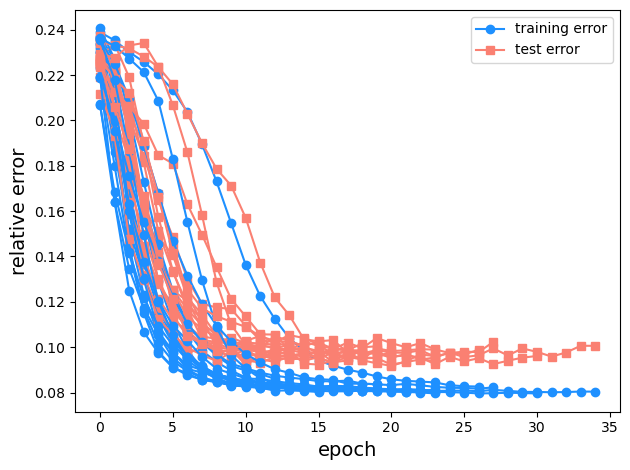

In [16]:
# plot the relative DAS training and test error for the last replica network
plot_errors(results_das)

### Get training results

In [17]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. 

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


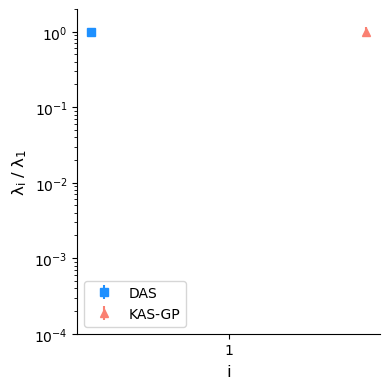

In [18]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_esmacs.csv')
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             yerr = GP_std[0:n_vals], fmt='^', color='salmon', label='KAS-GP')
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/esmacs_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [19]:
# run the DAS surrogate a a number of random inputs locations
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])

In [20]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T

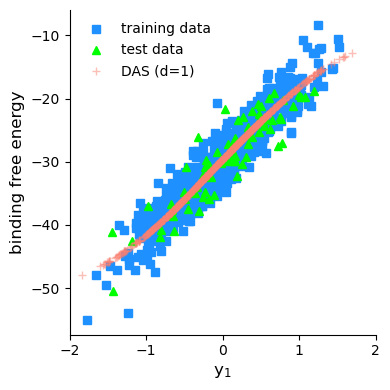

In [21]:
# QoI labels
lbl = {QoI: r'binding free energy'}

# plot DAS surrogate
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111,  xlim=[-2,2])    #E11 range
#ax = fig.add_subplot(111, ylim = [0.15, 0.45], xlim= [-2, 2]) # Poisson range
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, 's', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', color='lime', label='test data') 
ax.plot(y_val_das[:,0], das_samples_pred, '+', color='salmon', label='DAS (d=%d)' % d, alpha=0.5)
leg = ax.legend(loc=0, frameon=False)
leg.set_draggable(True)
sns.despine(top=True)
plt.tight_layout()
plt.savefig('./images/epoxy_surrogate_d1_%s.png' % (QoI, ))


### Recreate the global-derivative based sensitivity plots

In [22]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_esmacs.csv')

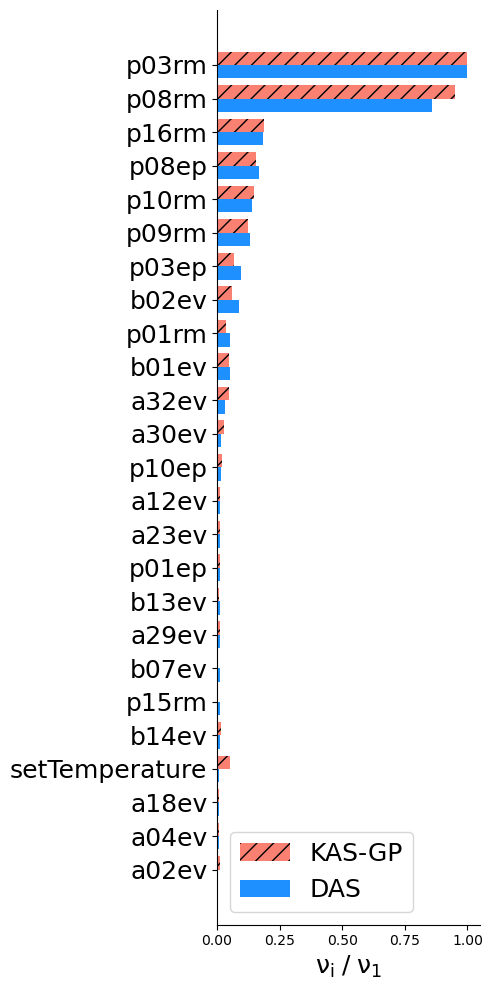

In [23]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


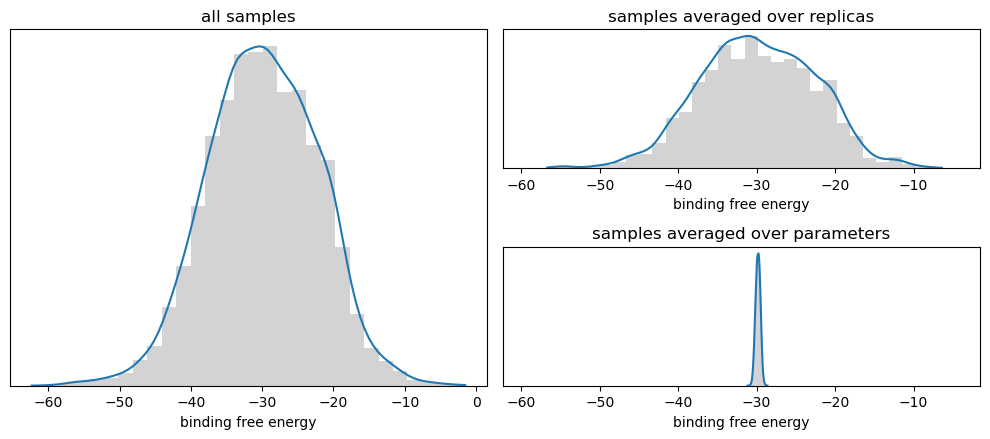

In [24]:
plot_dist(output, 'binding free energy')

### (Non-Gaussian) stats with bootstrapping

In [25]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:48<00:00, 438.10it/s]


In [26]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [27]:
print("Mean: %.2e (%.2e/%.2e)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2e (%.2e/%.2e)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.3f/%.3f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: -2.99e+01 (-2.99e+01/-2.98e+01)
Std dev: 7.68e+00 (7.61e+00/7.74e+00)
Skew: -0.08 (-0.117/-0.050)
Kurt: 0.07 (0.00/0.14)
N_samples = 18400
